## Part 2: Q-Learning in the Hospital Environment

### 2.1. The Motivation

In the last part, we tried to find the optimal policy in the Hospital Environment using the Backward Induction algorithm. And we have identified it's 2 major limitations:

* It can only be applied to environments with a known transition model. (While in reality, the model could be hard to obtain or even unknown)

* It is computationally expensive, as it compute the best possible action for all states at all stages. (Practically, we should only spend more time on states that are more likely to be visited)
Here, we will apply a reinforcement learning algorithm called Q-Learning to solve the Hospital problem.

Q-Learning is a model-free reinforcement learning algorithm used to find the optimal action-selection policy for a given finite Markov decision process. It helps an agent (like a robot, a computer program, or even a human) learn how to choose optimal actions that yield the most reward over time, even when it doesn't know anything about its environment initially.

Q-Learning could address the limitations of Backward Induction as follows:

* Q-Learning does not require a known transition model of the environment. It operates in a model-free manner, learning the optimal policy through interactions with the environment. This makes it particularly useful for real-world scenarios where the environment model may be complex, incomplete, or entirely unknown.

* Another advantage of Q-Learning is its computational efficiency. Unlike Backward Induction, which evaluates every possible state-action pair at each stage, Q-Learning focuses on learning the 'quality' value of state-action pairs that the agent actually encounters. This results in a more efficient use of computational resources, as the algorithm naturally prioritizes states that are more likely to be visited.

In this part, we will focusing on:

* Implement the Q-Learning algorithm to find the optimal policy in the Hospital Environment.

* Compare the runtime and performance between Q-Learning and Backward Induction, and discuss the potential causes of such result.


### 2.2. Building the Q-Learning Agent

#### Modification of the Environment

* The Hospital Environment from the last part is already defined by a MDP. But we still need to make a few modifications to make it interactable with the agent.
    * First, in each episode, the agent need to start from the initial state. So we need to add a reset() function to the environment, which returns the initial state.
    * Second, in each stage, the agent need to take an action and receive a reward / cost from the environment. So we need to add a step() function to the environment, which takes an action as input and returns the next state, reward and whether the episode is finished. Also, the step() function should inform the agent when it reaches the terminal state.


#### The Q-Learning Agent

A Q-Learning Agent has the following components:

* Q-Function: $Q(x_t, u_t)$
    * Recall the cost-to-go function $J(x_t)$ from the last part,
        * $J_t(x_t) = \min_{u_t} \{g_t(x_t,u_t) + E\{J_{t+1}(f_t(x_t,u_t))\}\}$
    * The Q-Function expands the cost/reward-to-go function by taking the action $u_t$ at stage $t$ into consideration:
        * $Q(x_t, u_t) = g_t(x_t,u_t) + E\{J_{t+1}(f_t(x_t,u_t))\}$
        * It takes the current state $x_t$ and action $u_t$ at stage $t$ as input, and returns the expected total reward from that state-action pair. Represening how good it is to take action $u_t$ at state $x_t$ at stage $t$. 
        > Since the 'Q' (may) stands for 'Quality', we will use reward instead of cost for now on, as is easy to convert the cost to reward by taking the negative of cost.
    * In Q-Learning, one way to represent the Q-Function is by a lookup table.
        * Here, `Q[t][x_t][u_t]` stores the Q-Function value of taking action $u_t$ at state $x_t$ at stage $t$.
        > Note: Unlike the others, the state is time-dependent in the Hospital Environment. While the state describe the queue length, the real state is the queue length at a specific time. So we always need to specify the time when we refer to a state.

* Learning Algorithm
    * The agent in the state $x_t$ at stage $t$ take an action $u_t$ by following the $\epsilon$-greedy policy:
        * $\pi(x_t) = \begin{cases} \text{random action} & \text{with probability } \epsilon \\ \arg\max_{u_t} Q(x_t, u_t) & \text{with probability } 1-\epsilon \end{cases}$
        * The $\epsilon$-greedy policy is a trade-off between exploration and exploitation. It allows the agent to explore the environment by taking random actions with probability $\epsilon$, and exploit the knowledge it has learned by taking the action with the highest Q-Function value with probability $1-\epsilon$.
        * Also, the $\epsilon$ decay strategy is used to make the agent explore less as it learns more.
    * It then receives a reward $r_t$ and the new state $x_{t+1}$ from the environment.
    * Based on these information, the agent learn by updating the Q-Function as follows:
        * $Q(x_t, u_t) \leftarrow (1-\alpha)Q(x_t, u_t) + \alpha(r_t + \gamma \max_{u_{t+1}} Q(x_{t+1}, u_{t+1}))$
        * The learning rate $\alpha$ controls how much the agent trust the new information.
        * The discount factor $\gamma$ controls how much the agent care about the future rewards. For a stationary environment like the hospital, we can set $\gamma = 1$.


> The detailed implementation of the Q-Learning Agent is in the `agent_QL.py` file.
* The training process:

    * Initialize the Q-Function to be all zeros
    * For each episode:
        * Reset the environment to the initial state
        * While the episode is not finished:
            * Take an action by following the epsilon-greedy policy
            * Receive the reward and the next state from the environment
            * Update the Q-Function by the learning algorithm



### 2.3. Q-Learning in action

Let's train the Q-Learning Agent first.

Finished training in 0.428 seconds


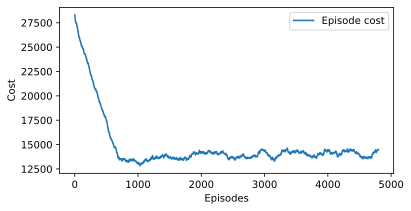

In [1]:
'''
Q-Learning in the Hospital Environment
'''
import numpy as np
from hospital_env import HospitalEnv
from agent_QL import AgentQL
from tools import plot_learning_curve, simulate

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')



# Assume the average number of new patients coming to the hospital is known
arrival_distrib = 5 + np.array([8, 6, 5, 4, 3, 3, 4, 5, 8, 12, 16, 18,
                                19, 18, 18, 18, 19, 18, 17, 16, 16, 14, 13, 9])

# Initialize the environment
hospital_env = HospitalEnv(arrival_distrib=arrival_distrib,
                            open_time=8,
                            work_hours=12,
                            patient_waiting_cost=30,
                            doc_cost=500,
                            waiting_capacity=60,
                            max_on_demand_doc=10,
                            patient_not_treated_cost=300,
                            default_queue_length=15)

# Define the Q-Learning agent
agent_ql = AgentQL(gamma=1, epsilon=1.0, lr=0.1,
                            n_stages=hospital_env.T,
                            n_states=hospital_env.waiting_capacity + 1,
                            n_actions=hospital_env.max_on_demand_doc + 1,
                            eps_min=0.01,
                            eps_dec=1e-4,
                            lr_min=0.01,
                            lr_dec=3e-7)

# Train the agent
def train_agent(agent_ql, hospital_env, n_episodes=200000, verbose=False):
    from time import time

    start = time()
    scores = []

    for i in range(1, n_episodes + 1):
        score = 0
        done = False
        state, stage = hospital_env.reset()
        
        while not done:
            action = agent_ql.choose_action(stage, state)
            (state_, stage_), cost, done = hospital_env.step(action)
            reward = -cost
            agent_ql.learn(stage, state, action, reward, state_, done)
            state, stage = state_, stage_
            score += cost

        scores.append(score)
        if verbose:
            avg_score = np.mean(scores[-100:]) if len(scores) >= 100 else np.mean(scores)

            if i % 10000 == 0:
                print('episode ', i, 'cost %.3f' % score,
                        'average cost %.3f' % avg_score,
                        'epsilon %.3f' % agent_ql.epsilon)
    training_time = time() - start
    print(f"Finished training in {training_time:.3f} seconds")
    policy = agent_ql.get_policy()

    return scores, policy, training_time



scores, policy_ql, time_ql = train_agent(agent_ql, hospital_env, n_episodes=5000)
# Plot the learning curve
plot_learning_curve(scores, 200, "Q-Learning", "Episodes", "Cost")

* As we can see, after 1000 episodes, the agent has learned a policy with cost around 14000 (with probability of 0.01 to take a random action). 
* Then the cost stop decreasing and fluctuate around this value.
* The actual cost produced from the simulator should be lower without exploration, and it is shown below:

In [2]:
# Simulate the environment with the given policy
avg_cost_ql = simulate(policy_ql, hospital_env)
print(f"\nAverage cost for Q-Learning agent: {avg_cost_ql}")

[ Simulating for 50000 episodes... ]

Average cost for Q-Learning agent: 13582.8028


Let's compare the policy and performance of Q-Learning and Backward Induction.

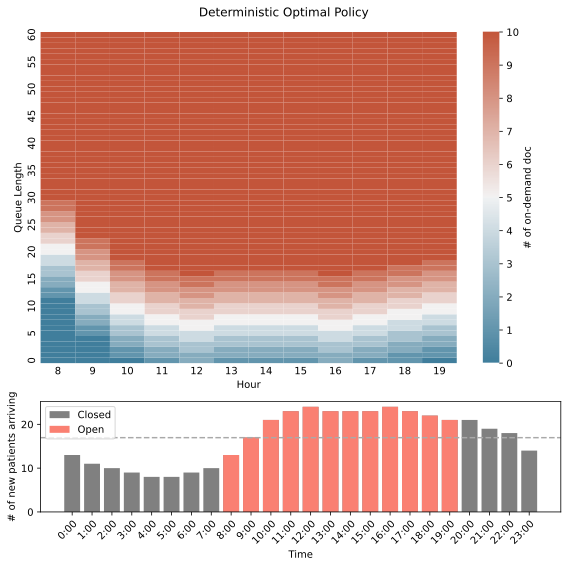

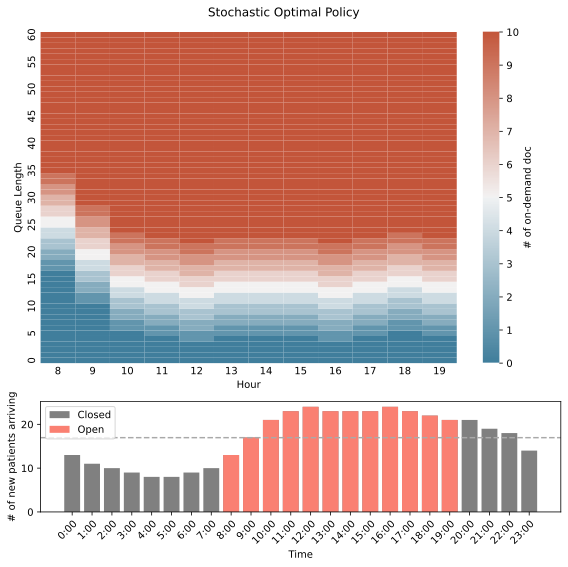

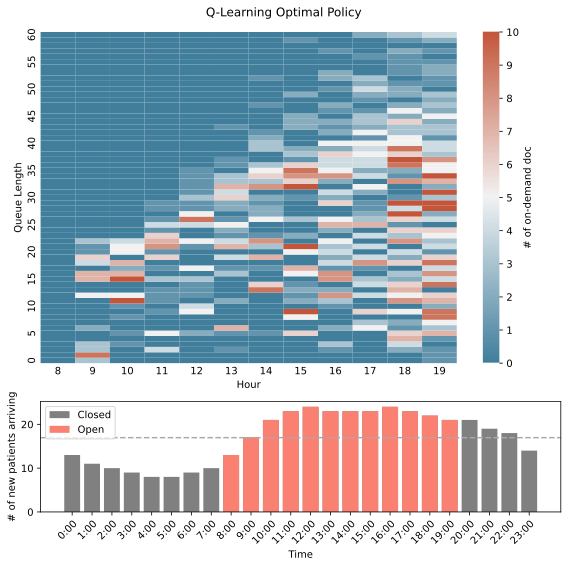

In [3]:
from BI_solver_det import BISolverDet
from BI_solver_sto import BISolverSto
from tools import simulate, plot_scores

# Solve the problem using backward induction
bi_solver_det = BISolverDet(hospital_env)
bi_solver_sto = BISolverSto(hospital_env)

policy_det, J_det = bi_solver_det.backward_induction()
policy_sto, J_sto = bi_solver_sto.backward_induction()

# Visualize the policies
hospital_env.visualize_policy(policy_det, title="Deterministic Optimal Policy")
hospital_env.visualize_policy(policy_sto, title="Stochastic Optimal Policy")
hospital_env.visualize_policy(policy_ql, title="Q-Learning Optimal Policy")


It seems like the Q-Learning agent is far-off from the true optimal policy given by the stochastic Backward Induction algorithm. It more looks like the result from a random policy, but is it?

Let's take a look of the simulation cost comparison.

[ Simulating for 50000 episodes... ]
Average cost for deterministic BI agent: 13536.833

[ Simulating for 50000 episodes... ]
Average cost for stochastic BI agent: 11249.3476

[ Simulating for 50000 episodes... ]
Average cost for Q-Learning agent: 13600.645
[ Simulating for 50000 episodes... ]
Average cost of the random policy: 34103.9056



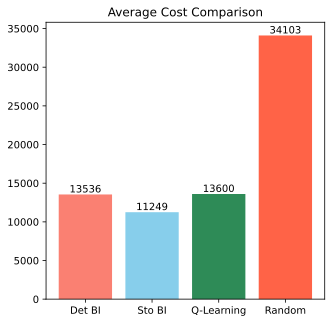

In [4]:
# Simulate the environment with the given policy
avg_cost_det = simulate(policy_det, hospital_env)
print(f"Average cost for deterministic BI agent: {avg_cost_det}\n")

avg_cost_sto = simulate(policy_sto, hospital_env)
print(f"Average cost for stochastic BI agent: {avg_cost_sto}\n")

avg_cost_ql = simulate(policy_ql, hospital_env)
print(f"Average cost for Q-Learning agent: {avg_cost_ql}")

random_policy = np.random.randint(0, len(hospital_env.action_space),
                                    size=(len(hospital_env.state_space), hospital_env.T))
avg_cost_rand = simulate(random_policy, hospital_env)
print(f"Average cost of the random policy: {avg_cost_rand}\n")

# Compare the average cost of the 4 policies
plot_scores([avg_cost_det, avg_cost_sto, avg_cost_ql, avg_cost_rand],
            ["Det BI", "Sto BI", "Q-Learning", "Random"],
            "Average Cost Comparison")


From the graph, the Q-Learning actually has a decent performance, not far from the optimal policy. And like the randomly generated policy, the Q-Learning agent have no knowledge of the model of the environment. But the Q-Learning agent is still able to learn a good approximation of the optimal policy by interacting with the environment.

So why the policy generated by Q-Learning looks so different from the optimal policy? In the policy graph, most of the actions are far from the optimal policy, but the cost is not that bad at all. Let's answer this question by checking how many times each states are visited by the agent.

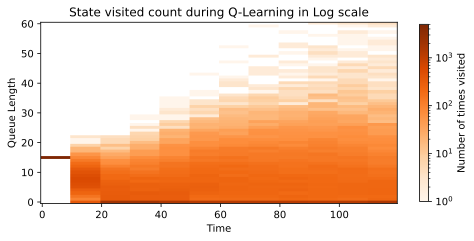

In [5]:
agent_ql.plot_state_visited_count((8, 4), "State visited count during Q-Learning in Log scale")

From the log-scaled heatmap, we can see the state in bottom part of the graph that representing shorter queue length are visited thousands even millions of times more than the top part of the graph. While the upper left part of the graph is barely visited at all by the agent through it's learning process. 


#### Exploration vs Exploitation
In our version of Q-Learning, the agent refine the policy of the state every time it reaches it. (By updating the Q-value of a state-action pair, so better action decision on the state could be made.) The agent can choose between an action of exploration or exploitation:

* Exploration allows the agent to take actions that are not currently estimated to be the best.
    * This make the agent acquire new information about the environment and may discover actions that are better than those it currently thinks are optimal.
    * However, too much exploration can be time consuming. Without using the knowledge it already has to narrow down the search, the agent ends up spending a lot of computational resources.
* Exploitation means taking the action that is currently estimated to yield the highest expected return.
    * We could limit the search space by exploiting a sub-optimal policy, stop wasting compuatation power on taking the currently sub-optimal action.
    * But focus only on exploitation, the agent might miss out on opportunities to find better solutions than those it is currently aware of.

Here, our Q-Learning agent uses the $\epsilon$-greedy action selection policy with $\epsilon$ decay that effectively balances exploration and exploitation during training. Initially, a high $\epsilon$ value encourages the agent to explore various actions and states, gathering essential information about the environment. As training progresses, $\epsilon$ is gradually reduced, shifting the agent's focus from exploration to exploitation. This allows the agent to fine-tune its policy based on acquired knowledge, optimizing its decisions to maximize rewards as it becomes more experienced.

As the agent continuously interacts with the environment, it naturally gravitates toward states that occur more frequently. These states receive more attention and are learned more thoroughly. On the other hand, when an agent visits a state less frequently, it perceives that state as less important within the context of the simulation. Therefore, the agent doesn't spend much time refining its policy for those infrequently occurring states.

That explains why the Q-Learning agent could still have a good performance while many of the policy generated does not match the optimal policy at all.

### 2.4. More experiments in a larger environment

In [6]:
'''
We'll borrow the large environment created from part 1
'''
hospital_env_large = HospitalEnv(arrival_distrib=5 + np.array([8, 6, 5, 4, 3, 3, 4, 5, 8, 12, 16, 18,
                                                        19, 18, 18, 18, 19, 18, 17, 16, 16, 14, 13, 9]),
                            open_time=4,
                            work_hours=16,
                            patient_waiting_cost=30,
                            doc_cost=500,
                            waiting_capacity=120,
                            max_on_demand_doc=40,
                            patient_not_treated_cost=300,
                            default_queue_length=15)

Training agent in environment for 30000 episodes
Finished training in 3.533 seconds


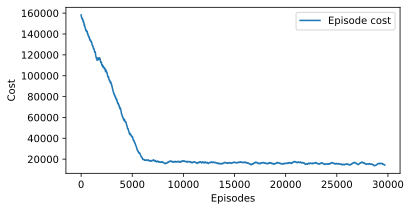

[ Simulating for 50000 episodes... ]

Average cost for Q-Learning agent: 12709.0698


In [7]:
hospital_env = hospital_env_large
agent_ql = AgentQL(gamma=1, epsilon=1.0, lr=0.6,
                            n_stages=hospital_env.T,
                            n_states=hospital_env.waiting_capacity + 1,
                            n_actions=hospital_env.max_on_demand_doc + 1,
                            eps_min=0.02,
                            eps_dec=1e-5,
                            lr_min=0.001,
                            lr_dec=7e-7)

n_episodes = 30000
# Train the agent
print(f"Training agent in environment for {n_episodes} episodes")
scores, policy_ql, time_ql = train_agent(agent_ql, hospital_env, n_episodes=n_episodes)

# Plot the learning curve
plot_learning_curve(scores, 300, "Q-Learning", "Episodes", "Cost")

# Simulate the environment with the given policy
avg_cost_ql = simulate(policy_ql, hospital_env)
print(f"\nAverage cost for Q-Learning agent: {avg_cost_ql}")


In [8]:
from time import time

# Solve the problem using backward induction
bi_solver_det = BISolverDet(hospital_env)
bi_solver_sto = BISolverSto(hospital_env)

print("Solving the problem using deterministic backward induction")
start = time()
policy_det, J_det = bi_solver_det.backward_induction()
time_bi_det = time() - start
print(f"Deterministic backward induction finished in {time_bi_det:.3f} seconds\n")

print("Solving the problem using stochastic backward induction")
start = time()
policy_sto, J_sto = bi_solver_sto.backward_induction()
time_bi_sto = time() - start
print(f"Stochastic backward induction finished in {time_bi_sto:.3f} seconds")

Solving the problem using deterministic backward induction
Deterministic backward induction finished in 0.199 seconds

Solving the problem using stochastic backward induction
Stochastic backward induction finished in 17.325 seconds


In [9]:
# Simulate the environment with the given policy
avg_cost_det = simulate(policy_det, hospital_env)
print(f"Average cost for deterministic BI agent: {avg_cost_det}\n")

avg_cost_sto = simulate(policy_sto, hospital_env)
print(f"Average cost for stochastic BI agent: {avg_cost_sto}\n")

avg_cost_ql = simulate(policy_ql, hospital_env)
print(f"Average cost for Q-Learning agent: {avg_cost_ql}")

random_policy = np.random.randint(0, len(hospital_env.action_space),
                                    size=(len(hospital_env.state_space), hospital_env.T))
avg_cost_rand = simulate(random_policy, hospital_env)
print(f"Average cost of the random policy: {avg_cost_rand}\n")

[ Simulating for 50000 episodes... ]
Average cost for deterministic BI agent: 11809.5496

[ Simulating for 50000 episodes... ]
Average cost for stochastic BI agent: 9869.4544

[ Simulating for 50000 episodes... ]
Average cost for Q-Learning agent: 12745.9734
[ Simulating for 50000 episodes... ]
Average cost of the random policy: 149956.0344



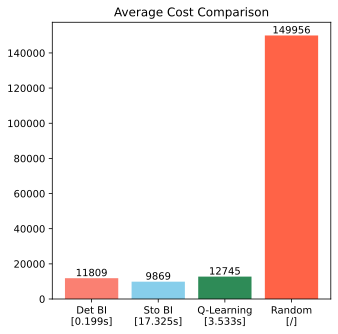

In [10]:
# Compare the average cost of the 4 policies
plot_scores([avg_cost_det, avg_cost_sto, avg_cost_ql, avg_cost_rand],
            [f"Det BI\n[{time_bi_det:.3f}s]",
             f"Sto BI\n[{time_bi_sto:.3f}s]",
             f"Q-Learning\n[{time_ql:.3f}s]",
             "Random\n[/]"],
            "Average Cost Comparison")

* Again, in this large environment, the Q-Learning agent is able to nearly match the performance of deterministic Backward Induction algorithm, while not far behind the stochastic BI which could be consider as the optimal policy.

* Though the Q-Learning could not match the performance of deterministic BI, it is still much quicker than the stochastic BI algorithm. This makes Q-Learning a more practical approach to solve a large problem, when a quick approximation algorithm like the deterministic BI is not available.

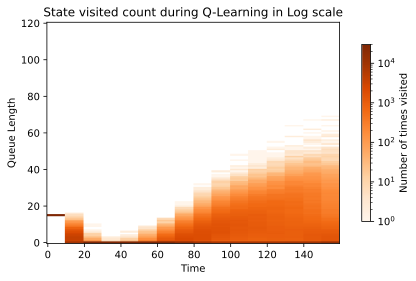

In [11]:
agent_ql.plot_state_visited_count((8, 4), "State visited count during Q-Learning in Log scale")

* From this graph, we can observe that the Q-Learning agent focused on a smaller propotion of state compare to the smaller environment earlier.

* As the complexity of the RL environment grows, the state space expands exponentially due to the curse of dimensionality, making the proportion of states that are actually useful for achieving the objective increasingly smaller. Hence the ability of Q-Learning agent to focus on 'important' states is the key to improve efficiency, making it suitable for larger problems.

### 2.5. Conclusion

#### Addressing Limitations of BI:
* Scalability:
    * Q-Learning successfully scales to larger environments, a significant limitation in traditional Backward Induction (BI) methods.
* State Focus: 
    * The algorithm concentrates on fewer states during learning, enabling quicker real-time decision-making—a feature not easily attainable with BI.

#### Performance of Q-Learning:
* Q-Learning comes close to achieving the optimal policy derived from BI methods, particularly impressive given its lack of knowledge about the environment's true model.
* The algorithm's performance is especially noteworthy when considering its reduced computational complexity compared to BI.

#### Runtime Efficiency of Q-Learning:

* Q-Learning demonstrates a runtime advantage over stochastic BI but falls short when compared to deterministic BI.
* Despite this, it remains a valuable alternative for near-optimal and rapid decision-making when deterministic BI is impractical.

#### Limitations of Q-Learning:
* Parameter Sensitivity: 
    * The performance and speed of Q-Learning are highly dependent on the tuning of its parameters, which could be a bottleneck in achieving optimal solutions.
    > I spent most of the time tuning the parameters rather than implimenting the code.
* Model Ignorance:
    * While the algorithm's lack of knowledge about the true environmental model can be an advantage, it could also lead to suboptimal policies if the model has complexities not captured during learning.
    > Could explain why the performance are closer to the sub-optimal deterministic BI, not the true optimal policy generated by stochastic BI.


> In the next part, we are going to look at an imporve version of Q-Learning, the Deep Q-Learning, along with other tricks to help it success in an alternative enviroment that is not approachable by Backward Induction.

